<a href="https://colab.research.google.com/github/sushiiel22bds0390/opendatasets/blob/master/soiltestfinal1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jovian --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
dataset_url='https://www.kaggle.com/datasets/jayaprakashpondy/soil-image-dataset'

In [ ]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sushiielanand
Your Kaggle Key: ··········


100%|██████████| 144M/144M [00:01<00:00, 108MB/s]


In [ ]:
data_dir1='/content/soil-image-dataset'
import os
os.listdir(data_dir1)

['Dataset']

In [ ]:
for cls in os.listdir(data_dir1):
  print(cls,':',len(os.listdir(data_dir1+'/'+cls)))


Dataset : 2


In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
datasets=ImageFolder(data_dir1)

In [ ]:
len(datasets)

1560

In [ ]:
datasets[0]

(<PIL.Image.Image image mode=RGB size=1018x1500>, 0)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

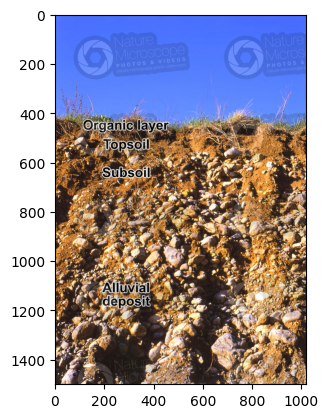

In [ ]:
img,label=datasets[0]
plt.imshow(img)

In [ ]:
import torchvision.transforms as tt


In [ ]:
import os
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
data_dir = "/content/soil-image-dataset"
file_list = os.listdir(data_dir)
jpg_files = [file for file in file_list if file.lower().endswith(".jpg")]
new_data_dir = "/content/soil-image-dataset"
os.makedirs(new_data_dir, exist_ok=True)
for jpg_file in jpg_files:
    source_path = os.path.join(data_dir, jpg_file)
    target_path = os.path.join(new_data_dir, jpg_file)
    shutil.copy(source_path, target_path)
dataset = ImageFolder(new_data_dir, tt.Compose([tt.Resize(64), tt.RandomCrop(64), tt.ToTensor()]))




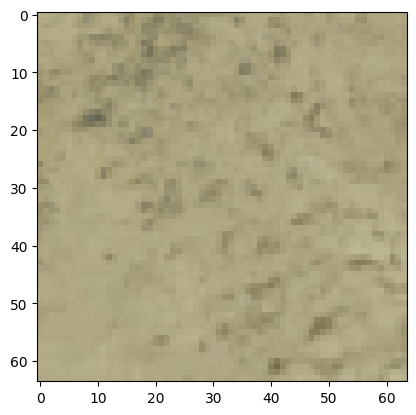

In [ ]:
img,label=dataset[94]
plt.imshow(img.permute((1,2,0)))


In [ ]:
val_pct=0.2
val_size=int(val_pct*len(dataset))
train_size=len(dataset)-val_size
train_size,val_size

(1248, 312)

In [ ]:
from torch.utils.data import random_split
train_ds,valid_ds=random_split(dataset,[train_size,val_size])
len(train_ds),len(valid_ds)


(1248, 312)

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size=64
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)
valid_dl = DataLoader(valid_ds,
                    batch_size*2,
                    num_workers=4,
                    pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from torchvision.utils import make_grid
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

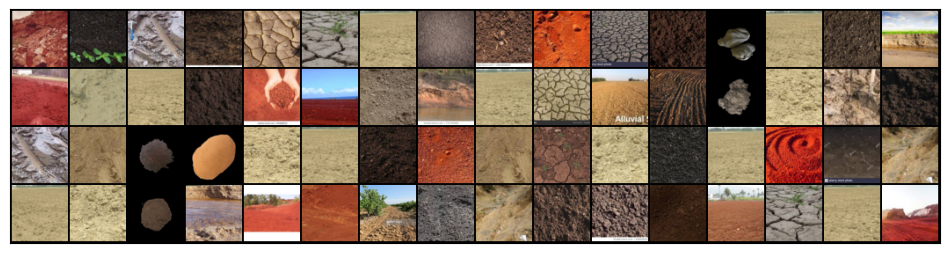

In [ ]:
show_batch(train_dl)

In [ ]:
import torch
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
torch.cuda.is_available()


False

In [ ]:
device=get_default_device()


In [ ]:
device

device(type='cpu')

In [ ]:
img,label=dataset[0]

In [ ]:
img.device

device(type='cpu')

In [ ]:
img_cpu=to_device(img,device)
img_cpu.device

device(type='cpu')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [ ]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        #78*3*64*64
        self.conv1 = conv_block(in_channels, 64)#78*64*64*64
        self.conv2 = conv_block(64, 128, pool=True)#78*128*32*32
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                        nn.Flatten(),
                                        nn.Dropout(0.5),
                                        nn.Linear(512, num_classes))
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model=to_device(ResNet9(3,len(dataset.classes)),device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
model.conv1[0].weight.device


device(type='cpu')

In [ ]:
for batch in train_dl:
  images,labels=batch
  print('image.shape',images.shape)
  print('images.device',images.device)
  preds=model(images)
  print('preds.shape',preds.shape)
  break


image.shape torch.Size([64, 3, 64, 64])
images.device cpu
preds.shape torch.Size([64, 1])


In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 0.0, 'val_acc': 1.0}]

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn, optim
def fit(epochs, learning_rate, model, train_dl, valid_dl, optimizer_fn):
    optimizer = optimizer_fn(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    history = {'train_loss': [], 'train_acc': [], 'valid_loss': [], 'valid_acc': []}
    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss, correct, total = 0, 0, 0
        for inputs, labels in train_dl:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = total_loss / len(train_dl)
        train_acc = correct / total
        model.eval()
        total_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in valid_dl:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        valid_loss = total_loss / len(valid_dl)
        valid_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['valid_loss'].append(valid_loss)
        history['valid_acc'].append(valid_acc)
        print(f'Epoch {epoch + 1}/{epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}')
    return history
history = fit(2, 0.01, model, train_dl, valid_dl, torch.optim.Adam)



Epoch 1/2, Train Loss: 0.0000, Train Acc: 1.0000, Valid Loss: 0.0000, Valid Acc: 1.0000
Epoch 2/2, Train Loss: 0.0000, Train Acc: 1.0000, Valid Loss: 0.0000, Valid Acc: 1.0000
